## Finding differentialy expressed miRNA's between LUAD stages I, II, III, IV vs normal using Logit regression

In [2]:
import os
import pandas
from definitions import ROOT_DIR

mirna_tumor_df = pandas.read_csv(os.path.join(ROOT_DIR, "data/processed/miRNA/tumor_miRNA.csv"))
mirna_normal_df = pandas.read_csv(os.path.join(ROOT_DIR, "data/processed/miRNA/normal_miRNA.csv"))
clinical_df = pandas.read_csv(os.path.join(ROOT_DIR, "data/processed/clinical/clinical.csv"))
validated_miRNA_csv = pandas.read_csv(os.path.join(ROOT_DIR, 'data/external/validated_luad_miRNAs_miRCancer.csv'))

print "mirna_tumor_df.shape", mirna_tumor_df.shape, ', nulls:', mirna_tumor_df.isnull().sum().sum()
print "mirna_normal_df.shape", mirna_normal_df.shape, ', nulls:', mirna_normal_df.isnull().sum().sum()
print 'validated_miRNAs.shape', validated_miRNA_csv.shape
 
X_normal = pandas.merge(clinical_df[['patient_barcode', 'pathologic_stage']], mirna_normal_df, on='patient_barcode')
X_normal['pathologic_stage'] = 'normal'
X_tumor = pandas.merge(clinical_df[['patient_barcode', 'pathologic_stage']], mirna_tumor_df, on='patient_barcode')

# Map stage IA to stage I, IB to I, etc. ...
pathologic_stage_map = {'Stage IA': 'Stage I', 'Stage IB': 'Stage I', 
                        'Stage IIA': 'Stage II', 'Stage IIB': 'Stage II', 
                        'Stage IIIA': 'Stage III', 'Stage IIIB': 'Stage III'}

X_tumor.replace({'pathologic_stage': pathologic_stage_map}, inplace=True)

print X_normal['pathologic_stage'].value_counts().sort_index(axis=0)
print X_tumor['pathologic_stage'].value_counts().sort_index(axis=0)

mirna_tumor_df.shape (513, 1882) , nulls: 0
mirna_normal_df.shape (46, 1882) , nulls: 0
validated_miRNAs.shape (34, 2)
normal    46
Name: pathologic_stage, dtype: int64
Stage I      277
Stage II     121
Stage III     84
Stage IV      24
Name: pathologic_stage, dtype: int64


mirna_tumor_df.shape (513, 1882) , nulls: 0
mirna_normal_df.shape (46, 1882) , nulls: 0
validated_miRNAs.shape (34, 2)
normal    46
Name: pathologic_stage, dtype: int64
Stage I      277
Stage II     121
Stage III     84
Stage IV      24
Name: pathologic_stage, dtype: int64


## We now create data matrixes from tumor vs normal samples

- We do not normalize the miRNA expression values because we are using Read Per Kilobase Million Mapped

In [22]:
X = pandas.concat([X_normal, X_tumor]).dropna(subset=['pathologic_stage'])
Y = X['pathologic_stage']

X_normal_vs_I = X[X['pathologic_stage'].isin(['normal', 'Stage I'])]
X_normal_vs_II = X[X['pathologic_stage'].isin(['normal', 'Stage II'])]
X_normal_vs_III = X[X['pathologic_stage'].isin(['normal', 'Stage III'])]
X_normal_vs_IV = X[X['pathologic_stage'].isin(['normal', 'Stage IV'])]
X_I_vs_II = X[X['pathologic_stage'].isin(['Stage I', 'Stage II'])]
X_II_vs_III = X[X['pathologic_stage'].isin(['Stage II', 'Stage III'])]
X_III_vs_IV = X[X['pathologic_stage'].isin(['Stage III', 'Stage IV'])]

Y_normal_vs_I = X_normal_vs_I['pathologic_stage']
Y_normal_vs_II = X_normal_vs_II['pathologic_stage']
Y_normal_vs_III = X_normal_vs_III['pathologic_stage']
Y_normal_vs_IV = X_normal_vs_IV['pathologic_stage']
Y_I_vs_II = X_I_vs_II['pathologic_stage']
Y_II_vs_III = X_II_vs_III['pathologic_stage']
Y_III_vs_IV = X_III_vs_IV['pathologic_stage']

X_normal_vs_I.__delitem__('patient_barcode')
X_normal_vs_I.__delitem__('pathologic_stage')
X_normal_vs_II.__delitem__('patient_barcode')
X_normal_vs_II.__delitem__('pathologic_stage')
X_normal_vs_III.__delitem__('patient_barcode')
X_normal_vs_III.__delitem__('pathologic_stage')
X_normal_vs_IV.__delitem__('patient_barcode')
X_normal_vs_IV.__delitem__('pathologic_stage')
X_I_vs_II.__delitem__('patient_barcode')
X_I_vs_II.__delitem__('pathologic_stage')
X_II_vs_III.__delitem__('patient_barcode')
X_II_vs_III.__delitem__('pathologic_stage')
X_III_vs_IV.__delitem__('patient_barcode')
X_III_vs_IV.__delitem__('pathologic_stage')

X.__delitem__('patient_barcode')
X.__delitem__('pathologic_stage')

print 'miRNA null values', X.isnull().sum().sum()
print 'Y null values', Y.isnull().sum()

print "X.shape", X.shape
print "Y.shape", Y.shape

mirna_list = X.columns.values
validated_miRNAs = set(validated_miRNA_csv['miRNA'].tolist())

miRNA null values 0
Y null values 0
X.shape (552, 1881)
Y.shape (552,)


### Logistic regression hyper-parameter selection for "C"

In [4]:
from sklearn.svm import l1_min_c
from matplotlib import pyplot as plt

cs = l1_min_c(X, Y, loss='log') * np.logspace(0, 1)
clf = linear_model.LogisticRegression(C=0.1, penalty='l1', fit_intercept=False)
coefs_ = []
for c in cs:
    clf.set_params(C=c)
    clf.fit(X, Y)
    coefs_.append(clf.coef_.ravel().copy())

coefs_ = np.array(coefs_)
plt.plot(cs, coefs_)
ymin, ymax = plt.ylim()
plt.xlabel('C')
plt.ylabel('Coefficients')
plt.title('Logistic Regression Path')
plt.axis('tight')
plt.show()

NameError: name 'np' is not defined

In [5]:
print "mirna_list", len(mirna_list)
print 'validated_miRNAs', len(validated_miRNAs)

print "number of validated miRNAs in list of all miRNAs", len(validated_miRNAs & set(mirna_list))

print Y_normal_vs_I.value_counts()
print Y_normal_vs_II.value_counts()
print Y_normal_vs_III.value_counts()
print Y_normal_vs_IV.value_counts()

mirna_list 1881
validated_miRNAs 27
number of validated miRNAs in list of all miRNAs 21
Stage I    277
normal      46
Name: pathologic_stage, dtype: int64
Stage II    121
normal       46
Name: pathologic_stage, dtype: int64
Stage III    84
normal       46
Name: pathologic_stage, dtype: int64
normal      46
Stage IV    24
Name: pathologic_stage, dtype: int64


## Perform classification for normal vs Stage I, Stage II, Stage III, and Stage IV


In [43]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics
import numpy as np

X_normal_vs_I_train, X_normal_vs_I_test, Y_normal_vs_I_train, Y_normal_vs_I_test = \
    train_test_split(X_normal_vs_I, Y_normal_vs_I, test_size=0.2, random_state=np.random.randint(0, 10000))

X_normal_vs_II_train, X_normal_vs_II_test, Y_normal_vs_II_train, Y_normal_vs_II_test = \
    train_test_split(X_normal_vs_II, Y_normal_vs_II, test_size=0.2, random_state=np.random.randint(0, 10000))

X_normal_vs_III_train, X_normal_vs_III_test, Y_normal_vs_III_train, Y_normal_vs_III_test = \
    train_test_split(X_normal_vs_III, Y_normal_vs_III, test_size=0.2, random_state=np.random.randint(0, 10000))

X_normal_vs_IV_train, X_normal_vs_IV_test, Y_normal_vs_IV_train, Y_normal_vs_IV_test = \
    train_test_split(X_normal_vs_IV, Y_normal_vs_IV, test_size=0.2, random_state=np.random.randint(0, 10000))


X_I_vs_II_train, X_I_vs_II_test, Y_I_vs_II_train, Y_I_vs_II_test = \
    train_test_split(X_I_vs_II, Y_I_vs_II, test_size=0.2, random_state=np.random.randint(0, 10000))

X_II_vs_III_train, X_II_vs_III_test, Y_II_vs_III_train, Y_II_vs_III_test = \
    train_test_split(X_II_vs_III, Y_II_vs_III, test_size=0.2, random_state=np.random.randint(0, 10000))

X_III_vs_IV_train, X_III_vs_IV_test, Y_III_vs_IV_train, Y_III_vs_IV_test = \
    train_test_split(X_III_vs_IV, Y_III_vs_IV, test_size=0.2, random_state=np.random.randint(0, 10000))


normal_vs_I =   linear_model.LogisticRegressionCV(Cs=list(np.power(10.0, np.arange(-3, 3))),
                                                  cv=3,
                                                  solver='liblinear',
                                                  penalty='l1',
                                                  fit_intercept=False)
normal_vs_II =  linear_model.LogisticRegressionCV(Cs=list(np.power(10.0, np.arange(-3, 3))),
                                                  cv=3,
                                                  solver='liblinear',
                                                  penalty='l1',
                                                  fit_intercept=False)
normal_vs_III = linear_model.LogisticRegressionCV(Cs=list(np.power(10.0, np.arange(-3, 3))),
                                                  cv=3,
                                                  solver='liblinear',
                                                  penalty='l1',
                                                  fit_intercept=False)
normal_vs_IV =  linear_model.LogisticRegressionCV(Cs=list(np.power(10.0, np.arange(-3, 3))),
                                                  cv=3,
                                                  solver='liblinear',
                                                  penalty='l1',
                                                  fit_intercept=False)

I_vs_II =  linear_model.LogisticRegressionCV(Cs=list(np.power(10.0, np.arange(-3, 3))),
                                                  cv=3,
                                                  solver='liblinear',
                                                  penalty='l1',
                                                  fit_intercept=False)

II_vs_III =  linear_model.LogisticRegressionCV(Cs=list(np.power(10.0, np.arange(-3, 3))),
                                                  cv=3,
                                                  solver='liblinear',
                                                  penalty='l1',
                                                  fit_intercept=False)

III_vs_IV =  linear_model.LogisticRegressionCV(Cs=list(np.power(10.0, np.arange(-3, 3))),
                                                  cv=3,
                                                  solver='liblinear',
                                                  penalty='l1',
                                                  fit_intercept=False)

print normal_vs_I.fit(X_normal_vs_I_train, Y_normal_vs_I_train)
print normal_vs_II.fit(X_normal_vs_II_train, Y_normal_vs_II_train)
print normal_vs_III.fit(X_normal_vs_III_train, Y_normal_vs_III_train)
print normal_vs_IV.fit(X_normal_vs_IV_train, Y_normal_vs_IV_train)
print I_vs_II.fit(X_I_vs_II_train, Y_I_vs_II_train)
print II_vs_III.fit(X_II_vs_III_train, Y_II_vs_III_train)
print III_vs_IV.fit(X_III_vs_IV_train, Y_III_vs_IV_train)

# print "\nClassification_report on training"
# print metrics.classification_report(y_train, model.predict(X_train), 
#                                     labels=['normal', 'Stage I', 'Stage II', 'Stage III', 'Stage IV'], 
#                                     target_names=['normal', 'Stage I', 'Stage II', 'Stage III', 'Stage IV'])
# print "classification_report on testing"
# print metrics.classification_report(y_test, model.predict(X_test), 
#                                     labels=['normal', 'Stage I', 'Stage II', 'Stage III', 'Stage IV'], 
#                                     target_names=['normal', 'Stage I', 'Stage II', 'Stage III', 'Stage IV'])
# print metrics.confusion_matrix(y_test, model.predict(X_test), 
#                                labels=['normal', 'Stage I', 'Stage II', 'Stage III', 'Stage IV'])

LogisticRegressionCV(Cs=[0.001, 0.01, 0.10000000000000001, 1.0, 10.0, 100.0],
           class_weight=None, cv=3, dual=False, fit_intercept=False,
           intercept_scaling=1.0, max_iter=100, multi_class='ovr',
           n_jobs=1, penalty='l1', random_state=None, refit=True,
           scoring=None, solver='liblinear', tol=0.0001, verbose=0)


LogisticRegressionCV(Cs=[0.001, 0.01, 0.10000000000000001, 1.0, 10.0, 100.0],
           class_weight=None, cv=3, dual=False, fit_intercept=False,
           intercept_scaling=1.0, max_iter=100, multi_class='ovr',
           n_jobs=1, penalty='l1', random_state=None, refit=True,
           scoring=None, solver='liblinear', tol=0.0001, verbose=0)


LogisticRegressionCV(Cs=[0.001, 0.01, 0.10000000000000001, 1.0, 10.0, 100.0],
           class_weight=None, cv=3, dual=False, fit_intercept=False,
           intercept_scaling=1.0, max_iter=100, multi_class='ovr',
           n_jobs=1, penalty='l1', random_state=None, refit=True,
           scoring=None, solver='liblinear', tol=0.0001, verbose=0)
LogisticRegressionCV(Cs=[0.001, 0.01, 0.10000000000000001, 1.0, 10.0, 100.0],
           class_weight=None, cv=3, dual=False, fit_intercept=False,
           intercept_scaling=1.0, max_iter=100, multi_class='ovr',
           n_jobs=1, penalty='l1', random_state=None, refit=True,
           scoring=None, solver='liblinear', tol=0.0001, verbose=0)


LogisticRegressionCV(Cs=[0.001, 0.01, 0.10000000000000001, 1.0, 10.0, 100.0],
           class_weight=None, cv=3, dual=False, fit_intercept=False,
           intercept_scaling=1.0, max_iter=100, multi_class='ovr',
           n_jobs=1, penalty='l1', random_state=None, refit=True,
           scoring=None, solver='liblinear', tol=0.0001, verbose=0)


LogisticRegressionCV(Cs=[0.001, 0.01, 0.10000000000000001, 1.0, 10.0, 100.0],
           class_weight=None, cv=3, dual=False, fit_intercept=False,
           intercept_scaling=1.0, max_iter=100, multi_class='ovr',
           n_jobs=1, penalty='l1', random_state=None, refit=True,
           scoring=None, solver='liblinear', tol=0.0001, verbose=0)


LogisticRegressionCV(Cs=[0.001, 0.01, 0.10000000000000001, 1.0, 10.0, 100.0],
           class_weight=None, cv=3, dual=False, fit_intercept=False,
           intercept_scaling=1.0, max_iter=100, multi_class='ovr',
           n_jobs=1, penalty='l1', random_state=None, refit=True,
           scoring=None, solver='liblinear', tol=0.0001, verbose=0)


## Show number of candidate miRNAs, top miRNA's based on coefficient, and percentage of known miRNA

In [44]:
from src.utils.validate_candidate_miRNAs import percent_candidate_in_validated
results = []

for model, name in zip([normal_vs_I, normal_vs_II, normal_vs_III, normal_vs_IV, I_vs_II, II_vs_III, III_vs_IV],
                       ['normal_vs_I', 'normal_vs_II', 'normal_vs_III', 'normal_vs_IV', 'I_vs_II',
                        'II_vs_III', 'III_vs_IV']):
    print '\n', name 
    non_zero_idx = np.nonzero(model.coef_.ravel())[0]
    print "Non-zero coef:", non_zero_idx.size
    df = pandas.DataFrame({"mirna": mirna_list[non_zero_idx],
                           "coefficient": model.coef_.ravel()[non_zero_idx]})
    print df.sort_values(by='coefficient', ascending=False).head(6)
    print df.sort_values(by='coefficient', ascending=True).head(6)
    
    print "Percentage of known NSCLC miRNAs:", percent_candidate_in_validated(df['mirna'].tolist(), validated_miRNAs)
    print set(df['mirna'].tolist()) & validated_miRNAs, len(set(df['mirna'].tolist()) & validated_miRNAs)
    
    results.append(df)


normal_vs_I
Non-zero coef: 16
    coefficient           mirna
4      0.000195  hsa-mir-103a-2
3      0.000179  hsa-mir-103a-1
13     0.000124     hsa-mir-30a
0      0.000100    hsa-let-7a-2
2      0.000054     hsa-mir-100
15     0.000035     hsa-mir-99b
    coefficient         mirna
8     -0.000527   hsa-mir-182
14    -0.000223   hsa-mir-30d
12    -0.000191    hsa-mir-22
7     -0.000179  hsa-mir-148a
5     -0.000093   hsa-mir-10a
10    -0.000059  hsa-mir-203a
Percentage of known NSCLC miRNAs: 0.0740740740741
set(['hsa-mir-200c', 'hsa-mir-30a']) 2

normal_vs_II
Non-zero coef: 147
     coefficient         mirna
131     0.006146   hsa-mir-598
114     0.004475  hsa-mir-374b
144     0.004009    hsa-mir-98
120     0.002834   hsa-mir-425
133     0.002512   hsa-mir-652
31      0.002404   hsa-mir-139
     coefficient          mirna
119    -0.017449    hsa-mir-424
121    -0.014281   hsa-mir-450b
136    -0.009320   hsa-mir-891a
83     -0.007911    hsa-mir-224
112    -0.006960   hsa-mir-365a
24  

In [45]:
for i in range(len(results)):
    for j in range(len(results)):
        print '\n', "Stage "+str(i+1)+' - Stage '+str(j+1), ' : ',len(set(results[i]['mirna'].tolist()) & set(results[j]['mirna'].tolist()))
        # print set(results[i]['mirna'].tolist()) & set(results[j]['mirna'].tolist())


Stage 1 - Stage 1  :  16

Stage 1 - Stage 2  :  16

Stage 1 - Stage 3  :  13

Stage 1 - Stage 4  :  11

Stage 1 - Stage 5  :  15

Stage 1 - Stage 6  :  16

Stage 1 - Stage 7  :  16

Stage 2 - Stage 1  :  16

Stage 2 - Stage 2  :  147

Stage 2 - Stage 3  :  21

Stage 2 - Stage 4  :  17

Stage 2 - Stage 5  :  68

Stage 2 - Stage 6  :  134

Stage 2 - Stage 7  :  65

Stage 3 - Stage 1  :  13

Stage 3 - Stage 2  :  21

Stage 3 - Stage 3  :  21

Stage 3 - Stage 4  :  15

Stage 3 - Stage 5  :  18

Stage 3 - Stage 6  :  21

Stage 3 - Stage 7  :  21

Stage 4 - Stage 1  :  11

Stage 4 - Stage 2  :  17

Stage 4 - Stage 3  :  15

Stage 4 - Stage 4  :  17

Stage 4 - Stage 5  :  14

Stage 4 - Stage 6  :  17

Stage 4 - Stage 7  :  17

Stage 5 - Stage 1  :  15

Stage 5 - Stage 2  :  68

Stage 5 - Stage 3  :  18

Stage 5 - Stage 4  :  14

Stage 5 - Stage 5  :  72

Stage 5 - Stage 6  :  72

Stage 5 - Stage 7  :  47

Stage 6 - Stage 1  :  16

Stage 6 - Stage 2  :  134

Stage 6 - Stage 3  :  21

Stage 6 

In [46]:
# print normal_vs_I.fit(X_normal_vs_I, Y_normal_vs_I)
# print normal_vs_II.fit(X_normal_vs_II, Y_normal_vs_II)
# print normal_vs_III.fit(X_normal_vs_III, Y_normal_vs_III)
# print normal_vs_IV.fit(X_normal_vs_IV, Y_normal_vs_IV)

print metrics.classification_report(Y_normal_vs_I_test, normal_vs_I.predict(X_normal_vs_I_test), 
                                    labels=['normal', 'Stage I'], 
                                    target_names=['normal', 'Stage I']) 
print metrics.classification_report(Y_normal_vs_II_test, normal_vs_II.predict(X_normal_vs_II_test), 
                                    labels=['normal', 'Stage II'], 
                                    target_names=['normal', 'Stage II']) 
print metrics.classification_report(Y_normal_vs_III_test, normal_vs_III.predict(X_normal_vs_III_test), 
                                    labels=['normal', 'Stage III'], 
                                    target_names=['normal', 'Stage III']) 
print metrics.classification_report(Y_normal_vs_IV_test, normal_vs_IV.predict(X_normal_vs_IV_test), 
                                    labels=['normal', 'Stage IV'], 
                                    target_names=['normal', 'Stage IV'])
print metrics.classification_report(Y_I_vs_II_test, I_vs_II.predict(X_I_vs_II_test), 
                                    labels=['Stage I', 'Stage II'], 
                                    target_names=['Stage I', 'Stage II'])
print metrics.classification_report(Y_II_vs_III_test, II_vs_III.predict(X_II_vs_III_test), 
                                    labels=['Stage II', 'Stage III'], 
                                    target_names=['Stage II', 'Stage III'])
print metrics.classification_report(Y_III_vs_IV_test, III_vs_IV.predict(X_III_vs_IV_test), 
                                    labels=['Stage III', 'Stage IV'], 
                                    target_names=['Stage III', 'Stage IV'])

             precision    recall  f1-score   support

     normal       0.83      1.00      0.91         5
    Stage I       1.00      0.98      0.99        60

avg / total       0.99      0.98      0.99        65

             precision    recall  f1-score   support

     normal       1.00      1.00      1.00        12
   Stage II       1.00      1.00      1.00        22

avg / total       1.00      1.00      1.00        34

             precision    recall  f1-score   support

     normal       0.83      1.00      0.91        10
  Stage III       1.00      0.88      0.93        16

avg / total       0.94      0.92      0.92        26

             precision    recall  f1-score   support

     normal       1.00      0.90      0.95        10
   Stage IV       0.80      1.00      0.89         4

avg / total       0.94      0.93      0.93        14

             precision    recall  f1-score   support

    Stage I       0.71      0.79      0.75        57
   Stage II       0.29      0.22 

177


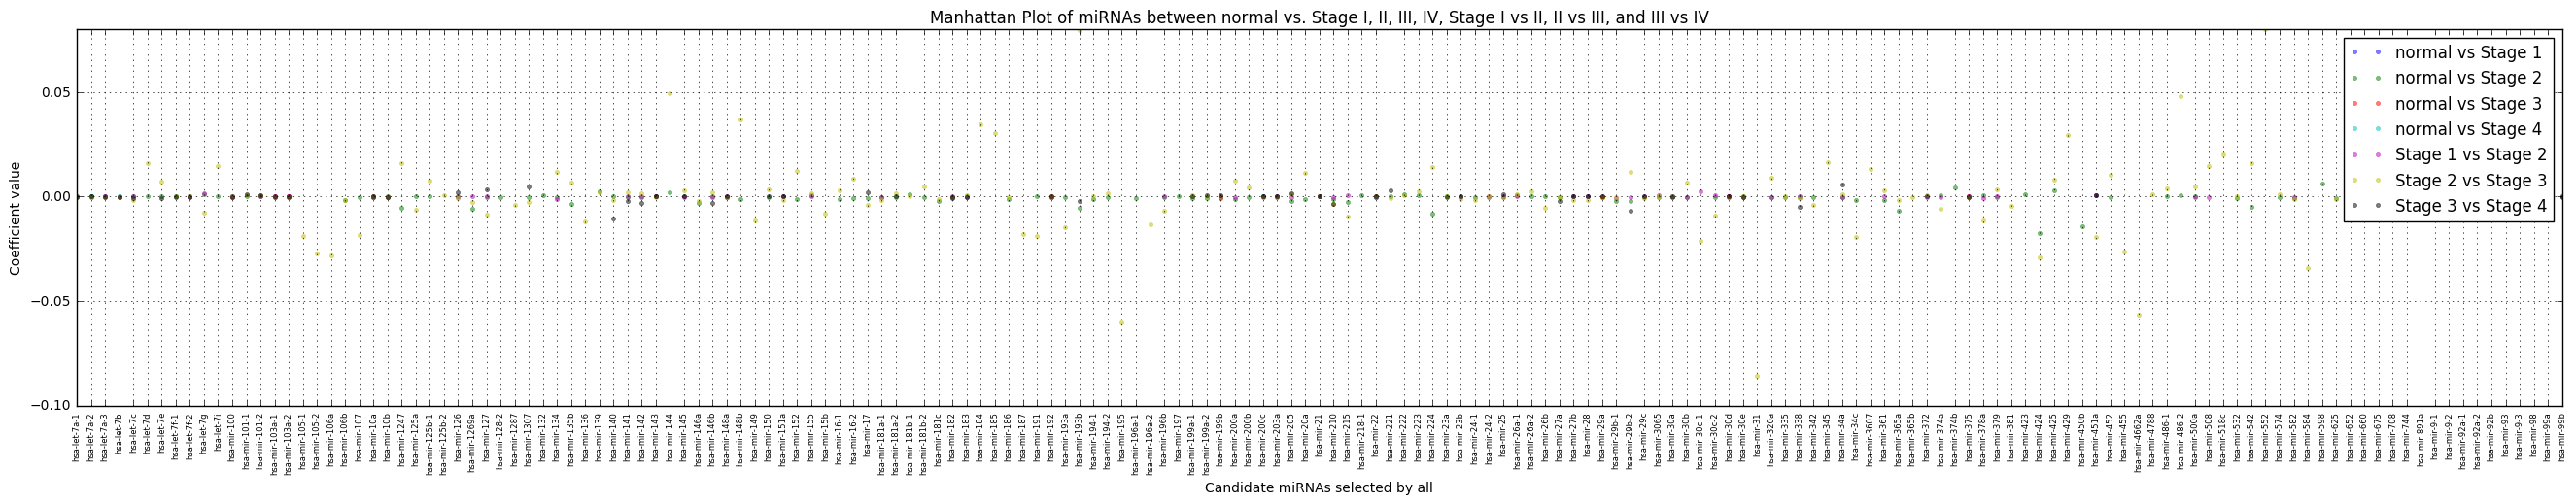

In [47]:
from matplotlib import pyplot as plt

all_candidate_miRNAs = set(results[0]['mirna']) | set(results[1]['mirna']) | set(results[2]['mirna']) | \
                       set(results[3]['mirna']) | set(results[4]['mirna']) | set(results[5]['mirna']) | \
                                                                               set(results[6]['mirna'])
sorted_candidate_miRNAs = []
for miR in mirna_list:
    if miR in all_candidate_miRNAs:
        sorted_candidate_miRNAs.append(miR)
print sorted_candidate_miRNAs.__len__()

plt.figure(figsize=(33, 5))
plt.xticks(range(sorted_candidate_miRNAs.__len__()), sorted_candidate_miRNAs, rotation='vertical', fontsize=6)

for i in [0,1,2,3,4,5,6]:
    x_indx = []
    y_values = []
    for x_str in results[i]['mirna']:
        # print all_candidate_miRNAs.index(x_str)
        x_indx.append(sorted_candidate_miRNAs.index(x_str))
    if i in [0,1,2,3]:
        for y_value in results[i]['coefficient']:
            y_values.append(y_value)
    else:
        for y_value in results[i]['coefficient']:
            y_values.append(-y_value)

    if i in [0,1,2,3]:
        plt.plot(x_indx, y_values, marker='.', linestyle='', alpha=0.5, label='normal vs Stage '+str(i+1))
    else:
        plt.plot(x_indx, y_values, marker='.', linestyle='', alpha=0.5, label='Stage '+ str(i-3) +' vs Stage '+str(i-2))

plt.legend()
plt.ylabel('Coefficient value')
plt.xlabel('Candidate miRNAs selected by all')
plt.title('Manhattan Plot of miRNAs between normal vs. Stage I, II, III, IV, Stage I vs II, II vs III, and III vs IV')
plt.axis('auto')
plt.grid(True)
plt.show()